In [17]:
%matplotlib inline

import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate

import tensorflow as tf

import time

extra_class = False

In [2]:
train_dir = '/home/ubuntu/data/processed/train.json'
test_dir = '/home/ubuntu/data/processed/test.json'

# Load data and calculate batch sizes
with open(train_dir) as data_file:    
    train_json = json.load(data_file) 
        
with open(test_dir) as data_file:    
    test_json = json.load(data_file)

In [3]:
angle_avg = 40.02188346578265

# Extract samples
def sample_extractor(data_json):
    
    samples = np.zeros((len(data_json), 75, 75, 2))
    angles = np.zeros(len(data_json))

    for index, sample in enumerate(data_json):
        band_1 = np.asarray(sample['band_1']).reshape(75,75)
        band_2 = np.asarray(sample['band_2']).reshape(75,75)
        samples[index][:,:,0] = band_1
        samples[index][:,:,1] = band_2
        inc_angle = sample['inc_angle']
        if isinstance(sample['inc_angle'], str):
            angles[index] = 0 #angle_avg
        else: 
            angles[index] = 0 #sample['inc_angle']
            
    return samples, angles
    
train_samples, train_angles = sample_extractor(train_json)
test_samples, test_angles = sample_extractor(test_json)

# Extract labels
labels = np.zeros(len(train_json))
for index, sample in enumerate(train_json):
    labels[index] = sample['is_iceberg']
    
# Extract IDs
test_id = []
for index, sample in enumerate(test_json):
    test_id.append(sample['id'])

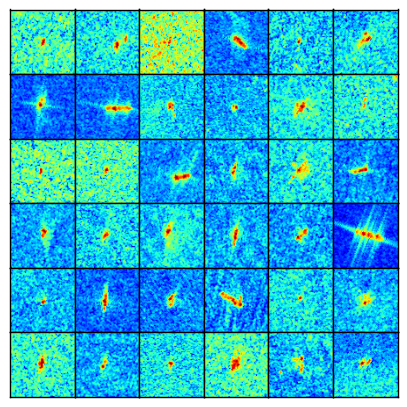

In [4]:
idx = np.random.randint(0, train_samples.shape[0], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(train_samples[ii,:,:,0], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

In [5]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    OldRange = (37.090523 - -49.0835)  # 37.090523 is the max pixel value, -49.0835 is the minimum
    NewRange = (1 - 0)  
    x = (((x - -49.0835) * NewRange) / OldRange) + 0
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [6]:
def data_aug(data, labels):
    
    def unison_shuffled_copies(a, b):
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        return a[p], b[p]

    train_samples, labels = unison_shuffled_copies(data, labels)


    # Create rotations of images
    rotations = np.zeros((len(train_samples), 75, 75, 2))
    for index, sample in enumerate(train_samples):
        rotation = rotate(sample, angle = np.random.randint(1, 10), reshape = False)
        rotations[index] = rotation

    # Create rotations of images
    rotations_2 = np.zeros((len(train_samples), 75, 75, 2))
    for index, sample in enumerate(train_samples):
        rotation = rotate(sample, angle = np.random.randint(1, 60), reshape = False)
        rotations_2[index] = rotation

    flips = np.zeros((len(train_samples), 75, 75, 2))
    for index, sample in enumerate(train_samples):
        flip = np.fliplr(sample)
        flips[index] = flip

    flipuds = np.zeros((len(train_samples), 75, 75, 2))
    for index, sample in enumerate(train_samples):
        flipud = np.flipud(sample)
        flipuds[index] = flipud
    
    
    x_train = np.concatenate((train_samples, rotations, rotations_2, flips, flipuds), axis=0)
    y_train = np.concatenate((labels, labels, labels, labels, labels), axis=0)


    return x_train, y_train

In [7]:
class Dataset:
    def __init__(self, labeled_data, unlabeled_data, labels, val_frac=0.2, shuffle=False, scale_func=None):
        
        # Split labeled data into train and validation
        split_idx = int(len(labeled_data)*(1 - val_frac))
        self.train_x, self.valid_x = labeled_data[:split_idx,:,:,:], labeled_data[split_idx:,:,:,:]
        self.train_y, self.valid_y = labels[:split_idx], labels[split_idx:]
        
        # Split test set out of training set
        split_idx = int(len(self.train_x)*(1 - val_frac))
        self.train_x, self.test_x = self.train_x[:split_idx,:,:,:], self.train_x[split_idx:,:,:,:]
        self.train_y, self.test_y = self.train_y[:split_idx], self.train_y[split_idx:]
        
        # Augment data
        self.train_x, self.train_y = data_aug( self.train_x, self.train_y)
        
        num_real = len(self.train_y)
        
        # Concat unlabeled and label data
        self.train_x = np.concatenate((self.train_x, unlabeled_data), axis=0)
        
        # Give unlabeled data a label
        y_unlabeled = np.zeros(len(unlabeled_data))
        
        
        # Concat labels
        self.train_y = np.concatenate((self.train_y, y_unlabeled), axis=0)
        
        # Use a label mask to indicate which labels are real
        self.label_mask = np.zeros_like(self.train_y)
        self.label_mask[0:num_real] = 1
        
        

        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.train_x = self.scaler(self.train_x)
        self.valid_x = self.scaler(self.valid_x)
        self.test_x = self.scaler(self.test_x)
        self.shuffle = shuffle
        
        
    def unison_shuffled_copies(a, b, c=None):
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        if c is not None:
            assert len(b) == len(c)
            return a[p], b[p], c[p]
        return a[p], b[p]
        
    def batches(self, batch_size, which_set="train"):
        x_name = which_set + "_x"
        y_name = which_set + "_y"
        dict_ = {"train_y":self.train_y, "train_x":self.train_x, "test_x":self.test_x, "test_y":self.test_y}
        
        num_examples = len(dict_[y_name])
        if self.shuffle:
            if which_set == "train":
                self.train_x, self.train_y, self.label_mask = unison_shuffled_copies(self.train_x, self.train_y, self.label_mask)
            else:
                self.train_x, self.train_y = unison_shuffled_copies(self.train_x, self.train_y)
        
        dataset_x = dict_[x_name]
        dataset_y = dict_[y_name]
        for ii in range(0, num_examples, batch_size):
            x = dataset_x[ii:ii+batch_size]
            y = dataset_y[ii:ii+batch_size]
            
            if which_set == "train":
                # When we use the data for training, we need to include
                # the label mask, so we can pretend we don't have access
                # to some of the labels, as an exercise of our semi-supervised
                # learning ability
                yield x, y.astype(int), self.label_mask[ii:ii+batch_size]
            else:
                yield x, y.astype(int)
                
    def test_data(self):
        return self.test_x, self.test_y.astype(int)

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, 75, 75, 2), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    y = tf.placeholder(tf.int32, (None), name='y')
    label_mask = tf.placeholder(tf.int32, (None), name='label_mask')
    
    return inputs_real, inputs_z, y, label_mask

In [9]:
def cnn_layer(layer, filters, strides=(1,1)):
    layer = tf.layers.conv2d(inputs=layer, filters=filters, kernel_size=(3,3), strides=strides, padding='same')
    layer = tf.layers.batch_normalization(layer, training=True)
    layer = tf.maximum(alpha * layer, layer)
    return layer
    

In [20]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = cnn_layer(x2, 256)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = cnn_layer(x3, 128)
        # 16x16x128 now
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=training)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = cnn_layer(x4, 64)
        # 32x32x64 now
        
        x5 = tf.layers.conv2d_transpose(x4, 32, 5, strides=2, padding='same')
        x5 = tf.layers.batch_normalization(x5, training=training)
        x5 = tf.maximum(alpha * x5, x5)
        x5 = cnn_layer(x5, 32)
        # 64x64x32 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x5, 2, 5, strides=2, padding='same')
        
        
        logits = tf.image.resize_image_with_crop_or_pad(
            logits,
            75,
            75
        )
        # 75x75x2 now
        
        out = tf.tanh(logits)
        
        return out

In [23]:
def discriminator(x, reuse=False, alpha=0.2, num_classes=2, drop_rate=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 75x75x2
        x0 = tf.layers.conv2d(x, 32, (64,64), strides=2, padding='same')
        relu0 = tf.maximum(alpha * x0, x0)
        relu0 = tf.layers.dropout(relu0, rate=drop_rate)
        
        x1 = tf.layers.conv2d(relu0, 64, (32,32), strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * bn1, bn1)
        relu1 = cnn_layer(relu1, 64)
        # 32x32x64
        
        x2 = tf.layers.conv2d(relu1, 128, (16,16), strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.layers.dropout(relu2, rate=drop_rate)
        relu2 = cnn_layer(relu2, 128)
        relu2 = cnn_layer(relu2, 128)
        # 16x16x128
        
        x3 = tf.layers.conv2d(relu2, 256, (8,8), strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3, rate=drop_rate)
        relu3 = cnn_layer(relu3, 256)
        relu3 = cnn_layer(relu3, 256)
        # 8x8x256
        
        x4 = tf.layers.conv2d(relu3, 512, (4,4), strides=2, padding='same')
        #bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * x4, x4)

        # Flatten it
        #flat = tf.reshape(relu4, (-1, 4*4*512))
        features = tf.reduce_mean(relu4, (1, 2)) # Average the height and wight (1,2)

        class_logits = tf.layers.dense(features, num_classes + extra_class)
        
        if extra_class:
            real_class_logits, fake_class_logits = tf.split(class_logits, [num_classes, 1], 1)
            assert fake_class_logits.get_shape()[1] == 1, fake_class_logits.get_shape()
            fake_class_logits = tf.squeeze(fake_class_logits)
        else:
            real_class_logits = class_logits
            fake_class_logits = 0.
        
        mx = tf.reduce_max(real_class_logits, 1, keep_dims=True)
        stable_real_class_logits = real_class_logits - mx

        gan_logits = tf.log(tf.reduce_sum(tf.exp(stable_real_class_logits), 1)) + tf.squeeze(mx) - fake_class_logits
        
        out = tf.nn.softmax(class_logits)
        
        return out, class_logits, gan_logits, features

In [24]:
def model_loss(input_real, input_z, output_dim, y, num_classes, label_mask, alpha=0.2, drop_rate=0.2):
    
    
    # These numbers multiply the size of each layer of the generator and the discriminator,
    # respectively. You can reduce them to run your code faster for debugging purposes.
    #g_size_mult = 32
    #d_size_mult = 64
    
    # Here we run the generator and the discriminator
    g_model = generator(input_z, output_dim, alpha=alpha)
    
    d_on_data = discriminator(input_real, alpha=alpha, drop_rate=drop_rate)
    
    d_model_real, class_logits_on_data, gan_logits_on_data, data_features = d_on_data
    
    d_on_samples = discriminator(g_model, reuse=True, alpha=alpha, drop_rate=drop_rate)
    
    d_model_fake, class_logits_on_samples, gan_logits_on_samples, sample_features = d_on_samples
    
    
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=gan_logits_on_data,
                                                labels=tf.ones_like(gan_logits_on_data)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=gan_logits_on_samples,
                                                labels=tf.zeros_like(gan_logits_on_samples)))
    y = tf.squeeze(y)
    
    class_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=class_logits_on_data,
                                                                  labels=tf.one_hot(y, num_classes + extra_class,
                                                                                    dtype=tf.float32))
    class_cross_entropy = tf.squeeze(class_cross_entropy)
    
    label_mask = tf.squeeze(tf.to_float(label_mask))
    
    d_loss_class = tf.reduce_sum(label_mask * class_cross_entropy) / tf.maximum(1., tf.reduce_sum(label_mask))
    
    d_loss = d_loss_class + d_loss_real + d_loss_fake
    
    
    
    data_moments = tf.reduce_mean(data_features, axis=0)
    sample_moments = tf.reduce_mean(sample_features, axis=0)
    g_loss = tf.reduce_mean(tf.abs(data_moments - sample_moments))
    

    pred_class = tf.cast(tf.argmax(class_logits_on_data, 1), tf.int32)
    eq = tf.equal(tf.squeeze(y), pred_class)
    correct = tf.reduce_sum(tf.to_float(eq))
    masked_correct = tf.reduce_sum(label_mask * tf.to_float(eq))
    
    return d_loss, g_loss, g_model, masked_correct, correct

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and biases to update. Get them separately for the discriminator and the generator
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    for t in t_vars:
        assert t in d_vars or t in g_vars

    # Minimize both players' costs simultaneously
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    shrink_lr = tf.assign(learning_rate, learning_rate * 0.9)
    
    return d_train_opt, g_train_opt, shrink_lr

In [26]:
class GAN:
    """
    A GAN model.
    :param real_size: The shape of the real data.
    :param z_size: The number of entries in the z code vector.
    :param learnin_rate: The learning rate to use for Adam.
    :param num_classes: The number of classes to recognize.
    :param alpha: The slope of the left half of the leaky ReLU activation
    :param beta1: The beta1 parameter for Adam.
    """
    def __init__(self, real_size, z_size, learning_rate, num_classes=2, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.learning_rate = tf.Variable(learning_rate, trainable=False)
        self.input_real, self.input_z, self.y, self.label_mask = model_inputs(real_size, z_size)
        self.drop_rate = tf.placeholder_with_default(.5, (), "drop_rate")
        
        loss_results = model_loss(self.input_real, self.input_z,
                                              real_size[2], self.y, num_classes, label_mask=self.label_mask,
                                                                          alpha=0.2,
                                                           drop_rate=self.drop_rate)
        self.d_loss, self.g_loss, self.samples, self.masked_correct, self.correct = loss_results
        
        self.d_opt, self.g_opt, self.shrink_lr = model_opt(self.d_loss, self.g_loss, self.learning_rate, beta1)

In [27]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        NewRange = (37.090523 - -49.0835)  # 37.090523 is the max pixel value, -49.0835 is the minimum
        OldRange = (1 - 0)  
        img = (((img - 0) * NewRange) / OldRange) + -49.0835
        ax.set_adjustable('box-forced')
        im = ax.imshow(img[:,:,0], aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

In [28]:
def train(net, dataset, epochs, batch_size, figsize=(5,5)):
    
    saver = tf.train.Saver()
    sample_z = np.random.normal(0, 1, size=(50, z_size))

    samples, train_accuracies, test_accuracies = [], [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            print("Epoch",e)
            
            t1e = time.time()
            num_examples = 0
            num_correct = 0
            for x, y, label_mask in dataset.batches(batch_size):
                assert 'int' in str(y.dtype)
                steps += 1
                num_examples += label_mask.sum()

                # Sample random noise for G
                batch_z = np.random.normal(0, 1, size=(batch_size, z_size))

                # Run optimizers
                t1 = time.time()
                _, _, correct = sess.run([net.d_opt, net.g_opt, net.masked_correct],
                                         feed_dict={net.input_real: x, net.input_z: batch_z,
                                                    net.y : y, net.label_mask : label_mask})
                t2 = time.time()
                num_correct += correct
                train_accuracy = num_correct / float(num_examples)

            sess.run([net.shrink_lr])
            
            
            train_accuracy = num_correct / float(num_examples)
            
            print("\t\tClassifier train accuracy: ", train_accuracy)
            
            num_examples = 0
            num_correct = 0
            x, y = dataset.test_data()#.batches(batch_size, which_set="test"):
            assert 'int' in str(y.dtype)
            num_examples += x.shape[0]

            correct, = sess.run([net.correct], feed_dict={net.input_real: x,
                                                   net.y : y,
                                                   net.drop_rate: 0.})
            num_correct += correct
            
            test_accuracy = num_correct / float(num_examples)
            print("\t\tClassifier test accuracy", test_accuracy)
            print("\t\tStep time: ", t2 - t1)
            t2e = time.time()
            print("\t\tEpoch time: ", t2e - t1e)
            
            
            gen_samples = sess.run(
                                   net.samples,
                                   feed_dict={net.input_z: sample_z})
            samples.append(gen_samples)
            _ = view_samples(-1, samples, 5, 10, figsize=figsize)
            plt.show()
            
            
            # Save history of accuracies to view after training
            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)
            

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return train_accuracies, test_accuracies, samples


In [ ]:
real_size = (75,75,2)
z_size = 100
learning_rate = 0.0002
batch_size = 64
epochs = 25
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

In [ ]:
dataset = Dataset(train_samples, test_samples, labels)

losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))